In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rocki37/open-university-learning-analytics-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rocki37/open-university-learning-analytics-dataset/versions/1


In [2]:
import pandas as pd
import os

# Set dataset path (update this after running your KaggleHub command)
dataset_path = "/root/.cache/kagglehub/datasets/rocki37/open-university-learning-analytics-dataset/versions/1"  # Replace with actual path

# Load datasets
student_info = pd.read_csv(f"{dataset_path}/studentInfo.csv")
student_vle = pd.read_csv(f"{dataset_path}/studentVle.csv")
assessments = pd.read_csv(f"{dataset_path}/assessments.csv")
student_assessments = pd.read_csv(f"{dataset_path}/studentAssessment.csv")

# 🔹 Print column names for debugging
print("✅ Loaded Datasets:")
print("\nStudent Info Columns:\n", student_info.columns.tolist())
print("\nStudent VLE Columns:\n", student_vle.columns.tolist())
print("\nAssessments Columns:\n", assessments.columns.tolist())
print("\nStudent Assessments Columns:\n", student_assessments.columns.tolist())


✅ Loaded Datasets:

Student Info Columns:
 ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result']

Student VLE Columns:
 ['code_module', 'code_presentation', 'id_student', 'id_site', 'date', 'sum_click']

Assessments Columns:
 ['code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'weight']

Student Assessments Columns:
 ['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score']


In [3]:
# 🔹 Merge student info with student assessments
df = student_info.merge(student_assessments, on='id_student', how='left')

# 🔹 Merge with assessments to include `code_module` & `code_presentation`
df = df.merge(assessments[['id_assessment', 'code_module', 'code_presentation', 'assessment_type', 'date', 'weight']], on='id_assessment', how='left')

# 🔹 Print merged DataFrame columns
print("\n✅ Columns in df after merging student info & assessments:\n", df.columns.tolist())




✅ Columns in df after merging student info & assessments:
 ['code_module_x', 'code_presentation_x', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'id_assessment', 'date_submitted', 'is_banked', 'score', 'code_module_y', 'code_presentation_y', 'assessment_type', 'date', 'weight']


In [4]:
# 🔹 Rename columns to ensure consistency before next merge
df.rename(columns={'code_module_x': 'code_module', 'code_presentation_x': 'code_presentation'}, inplace=True)

# 🔹 Drop duplicate columns from assessments
df.drop(columns=['code_module_y', 'code_presentation_y'], inplace=True)

# 🔹 Print cleaned column names
print("\n✅ Cleaned Columns in df Before Merging student_vle:\n", df.columns.tolist())



✅ Cleaned Columns in df Before Merging student_vle:
 ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'id_assessment', 'date_submitted', 'is_banked', 'score', 'assessment_type', 'date', 'weight']


In [5]:
# 🔹 Load required libraries
import pandas as pd
import os

# 🔹 Set dataset path
dataset_path = "/root/.cache/kagglehub/datasets/rocki37/open-university-learning-analytics-dataset/versions/1"

# 🔹 Load datasets
student_info = pd.read_csv(f"{dataset_path}/studentInfo.csv")
student_vle = pd.read_csv(f"{dataset_path}/studentVle.csv")
assessments = pd.read_csv(f"{dataset_path}/assessments.csv")
student_assessments = pd.read_csv(f"{dataset_path}/studentAssessment.csv")

# 🔹 Merge student info with assessments first (before adding `student_vle`)
df = student_info.merge(student_assessments, on='id_student', how='left')
df = df.merge(assessments, on='id_assessment', how='left')

# 🔹 Rename and drop duplicate columns to prevent errors
df.rename(columns={'code_module_x': 'code_module', 'code_presentation_x': 'code_presentation'}, inplace=True)
df.drop(columns=['code_module_y', 'code_presentation_y'], inplace=True)

# 🔹 Reduce `student_vle` size by filtering only relevant students
student_vle_filtered = student_vle[student_vle['id_student'].isin(df['id_student'])]

# 🔹 Select necessary columns only
student_vle_filtered = student_vle_filtered[['id_student', 'id_site', 'date', 'sum_click']]
print("\n✅ student_vle_filtered Shape (After Reduction):", student_vle_filtered.shape)




✅ student_vle_filtered Shape (After Reduction): (10655280, 4)


In [6]:
# 🔹 Aggregate `sum_click` for each student to reduce row count
student_vle_grouped = student_vle_filtered.groupby('id_student', as_index=False)['sum_click'].sum()

# 🔹 Print new shape after aggregation
print("\n✅ student_vle_grouped Shape (After Aggregation):", student_vle_grouped.shape)



✅ student_vle_grouped Shape (After Aggregation): (26074, 2)


In [7]:
# 🔹 Convert data types to optimize memory usage
df['id_student'] = df['id_student'].astype('int32')
student_vle_grouped['id_student'] = student_vle_grouped['id_student'].astype('int32')

# 🔹 Merge aggregated `sum_click` safely
df = df.merge(student_vle_grouped, on='id_student', how='left')

# 🔹 Fill NaN values in `sum_click` with 0 (if needed)
df['sum_click'] = df['sum_click'].fillna(0).astype('int16')

# 🔹 Print final dataset shape
print("\n✅ Final Merged Dataset Shape:", df.shape)



✅ Final Merged Dataset Shape: (213166, 20)


In [8]:
# 🔹 Check missing values
missing_values = df.isnull().sum()
print("\n🛑 Missing Values:\n", missing_values[missing_values > 0])

# 🔹 Fill missing values intelligently
df['sum_click'].fillna(0, inplace=True)  # Replace NaN clicks with 0
df['score'].fillna(df['score'].median(), inplace=True)  # Replace NaN scores with median value

# 🔹 Drop rows if too many missing values
df.dropna(thresh=15, inplace=True)  # Drop rows with more than 5 missing values



🛑 Missing Values:
 imd_band           9413
id_assessment      5847
date_submitted     5847
is_banked          5847
score              6074
assessment_type    5847
date               9865
weight             5847
dtype: int64


<ipython-input-8-c4c2548e2c70>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sum_click'].fillna(0, inplace=True)  # Replace NaN clicks with 0
<ipython-input-8-c4c2548e2c70>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [9]:
# 🔹 Fill missing categorical values with "Unknown"
df['imd_band'] = df['imd_band'].fillna("Unknown")
df['assessment_type'] = df['assessment_type'].fillna("Unknown")

# 🔹 Fill missing numerical values
df['sum_click'] = df['sum_click'].fillna(0)  # No engagement = 0 clicks
df['score'] = df['score'].fillna(df['score'].median())  # Use median for score
df['weight'] = df['weight'].fillna(df['weight'].median())  # Use median for weight

# 🔹 Fill missing dates with placeholder values
df['date_submitted'] = df['date_submitted'].fillna(-1)  # No submission = -1
df['date'] = df['date'].fillna(-1)  # No date available = -1

# 🔹 Fill missing "is_banked" values (assuming binary 0/1)
df['is_banked'] = df['is_banked'].fillna(0)  # Assume 0 (not banked)

# 🔹 Drop rows where `id_assessment` is missing (since it's critical)
df = df.dropna(subset=['id_assessment'])

# 🔹 Re-check missing values
print("\n✅ Missing Values After Cleaning:\n", df.isnull().sum())



✅ Missing Values After Cleaning:
 code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
id_assessment           0
date_submitted          0
is_banked               0
score                   0
assessment_type         0
date                    0
weight                  0
sum_click               0
dtype: int64


In [10]:
from sklearn.preprocessing import LabelEncoder

# 🔹 List of categorical features to encode
categorical_features = ['code_module', 'code_presentation', 'gender', 'region',
                        'highest_education', 'imd_band', 'age_band', 'disability',
                        'final_result', 'assessment_type']

# 🔹 Apply Label Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for later use (optional)


In [11]:
from sklearn.preprocessing import MinMaxScaler

# 🔹 List of numerical features to scale
numerical_features = ['num_of_prev_attempts', 'studied_credits', 'date_submitted',
                      'score', 'date', 'weight', 'sum_click']

# 🔹 Apply MinMax Scaling (scales values between 0 and 1)
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [12]:
# 🔹 Define target variable (Predicting 'final_result')
X = df.drop(columns=['final_result'])  # Features
y = df['final_result']  # Target variable


In [13]:
from sklearn.model_selection import train_test_split

# 🔹 Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check sizes
print("\n✅ Training Set Size:", X_train.shape)
print("✅ Testing Set Size:", X_test.shape)



✅ Training Set Size: (165855, 19)
✅ Testing Set Size: (41464, 19)


In [14]:
# Drop only existing columns
columns_to_drop = ['code_module', 'code_presentation', 'id_student', 'id_assessment', 'id_site']

# Filter out non-existent columns
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop columns safely
df_cleaned = df.drop(columns=columns_to_drop)

# Check new shape
print("New DF Shape After Dropping Irrelevant Columns:", df_cleaned.shape)



New DF Shape After Dropping Irrelevant Columns: (207319, 16)


## **Exploratory Data Analysis**

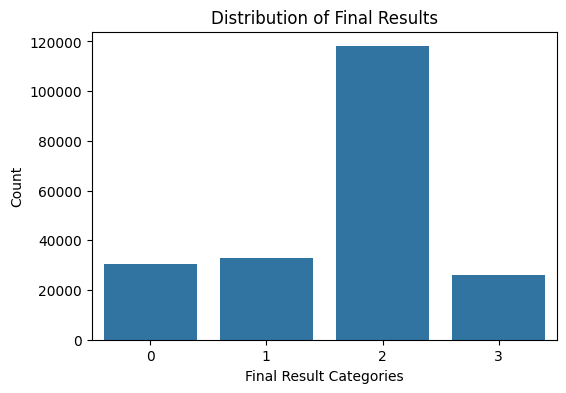

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df_cleaned['final_result'])
plt.title("Distribution of Final Results")
plt.xlabel("Final Result Categories")
plt.ylabel("Count")
plt.show()


# **Applying class weights to handle imbalance**

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
classes = np.unique(y_train)

# Compute class weights (balanced)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

# Print class weights
print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 1.7080844490216271, 1: 1.571727758614154, 2: 0.439141601355645, 3: 1.9954641705568121}


# **Feature Correlation Analysis**

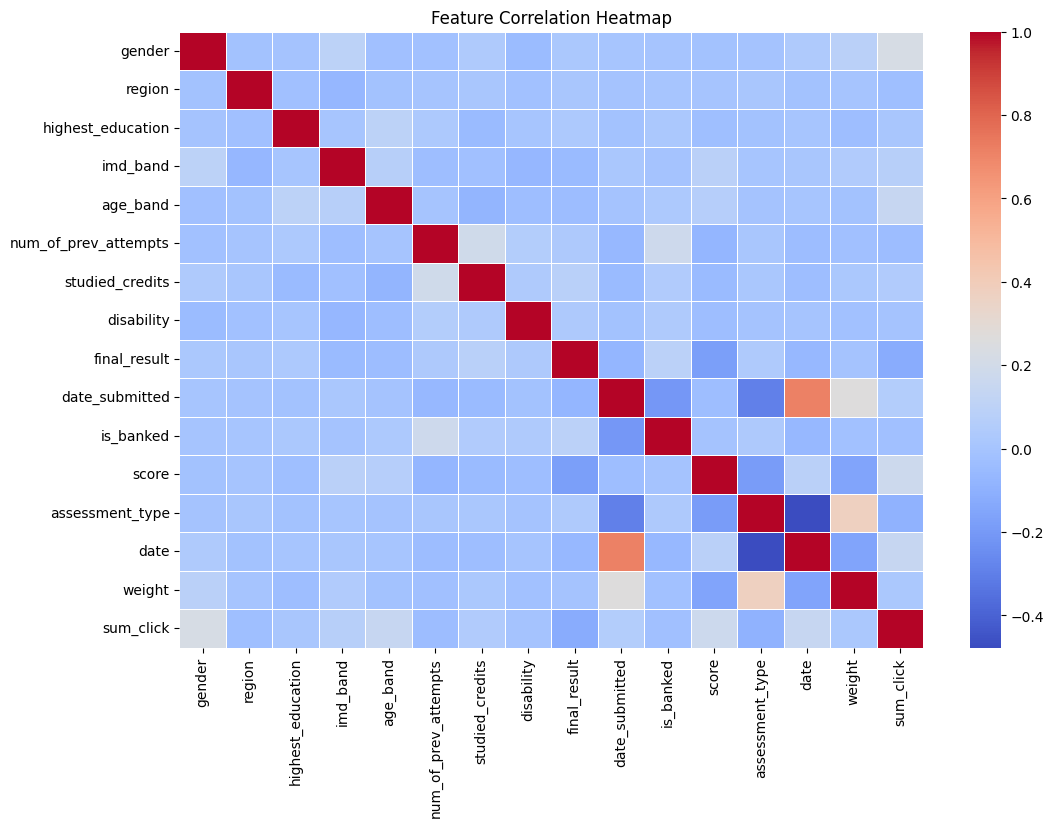

🛑 Highly Correlated Features to Drop: set()

✅ Shape After Feature Selection: (207319, 16)


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation matrix
correlation_matrix = df_cleaned.corr()

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify highly correlated features
threshold = 0.85
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print("🛑 Highly Correlated Features to Drop:", correlated_features)

# Drop highly correlated features
df_cleaned = df_cleaned.drop(columns=correlated_features)

print("\n✅ Shape After Feature Selection:", df_cleaned.shape)


📌 Features to Drop (If Correlation > 0.85)

In [18]:
threshold = 0.85  # Set correlation threshold
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Drop identified features
df_cleaned = df_cleaned.drop(columns=correlated_features)

print("✅ Dropped Highly Correlated Features:", correlated_features)
print("📊 New DF Shape After Feature Selection:", df_cleaned.shape)


✅ Dropped Highly Correlated Features: set()
📊 New DF Shape After Feature Selection: (207319, 16)


### **Implementing the MLP Model**

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Convert labels to categorical format (One-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, num_classes=4)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=4)

# ✅ Use your computed class weights
class_weights_dict = {0: 1.7080844490216271,
                      1: 1.571727758614154,
                      2: 0.439141601355645,
                      3: 1.9954641705568121}

# Define the MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input Layer
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),  # Hidden Layer 1
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden Layer 2
    Dense(4, activation='softmax')  # Output Layer (4 classes)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,  # ✅ Use computed class weights
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.2482 - loss: 1710.2570 - val_accuracy: 0.1591 - val_loss: 1.3854
Epoch 2/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.2949 - loss: 1.7727 - val_accuracy: 0.1253 - val_loss: 1.3861
Epoch 3/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.2291 - loss: 1.4185 - val_accuracy: 0.1591 - val_loss: 1.3807
Epoch 4/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.2199 - loss: 1.3918 - val_accuracy: 0.1253 - val_loss: 1.3894
Epoch 5/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.2094 - loss: 1.4583 - val_accuracy: 0.1253 - val_loss: 1.3946
Epoch 6/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.1707 - loss: 1.3899 - val_accuracy: 0.1591 - val_loss: 1.3796
Epoch 7/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.2468 - loss: 1.4049 - val_accuracy: 0.1253 - val_loss: 1.3939
Epoch 8/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.1886 - loss

### **1. Model Evaluation & Visualization**
Before making improvements, let's analyze the model's performance. Here's what we'll do:

1️⃣ Plot Training vs. Validation Accuracy & Loss Curves

2️⃣ Confusion Matrix to Check Class-wise Performance

3️⃣ Precision, Recall, and F1-score for better **insights**

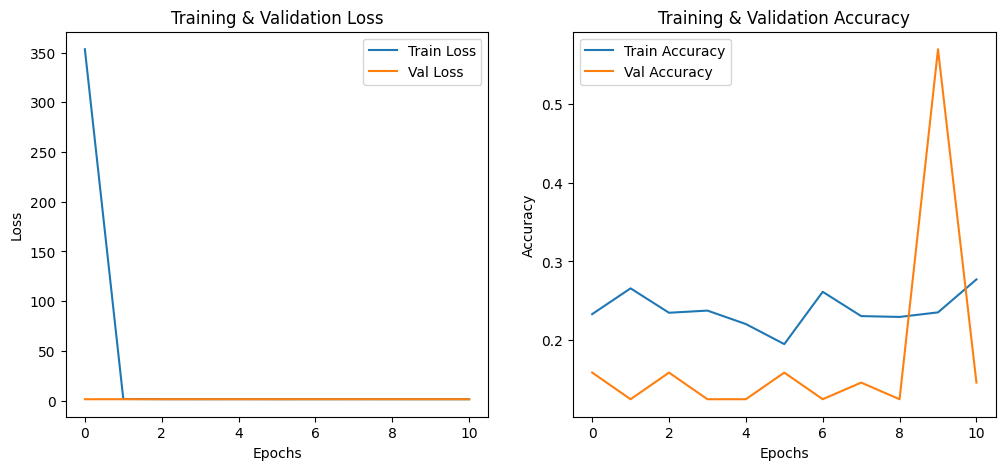

1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


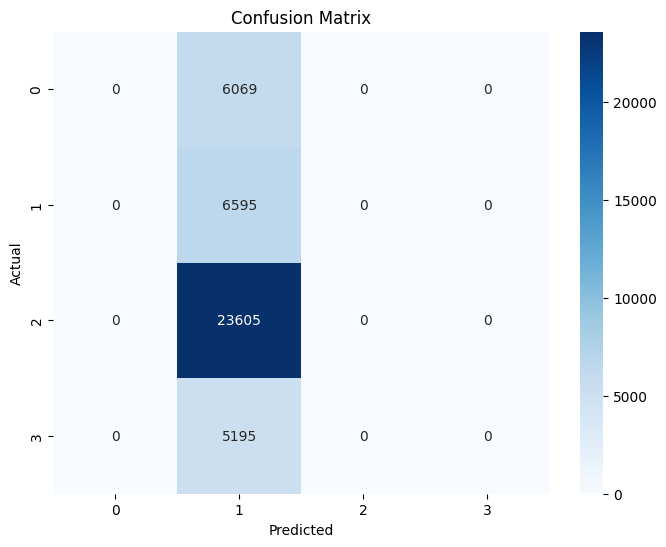

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6069
           1       0.16      1.00      0.27      6595
           2       0.00      0.00      0.00     23605
           3       0.00      0.00      0.00      5195

    accuracy                           0.16     41464
   macro avg       0.04      0.25      0.07     41464
weighted avg       0.03      0.16      0.04     41464



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 📊 Plot training & validation curves
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

# 🔥 Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 📌 Classification Report (Precision, Recall, F1-score)
print("Classification Report:\n", classification_report(y_true, y_pred_classes))


# Oversample the Minority Classes

Increase the number of samples in underrepresented classes using SMOTE or simple duplication.



In [21]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("New Training Data Shape:", X_train_resampled.shape)


New Training Data Shape: (377680, 19)


Improve Model Architecture
Adding:

More hidden layers or neurons

Batch Normalization (stabilizes learning)

Dropout Layers (prevents overfitting)

In [22]:
import tensorflow as tf
print(tf.__version__)  # Should print a version number (e.g., 2.9.1)


2.18.0


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input Layer
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # Adjust output layer based on your number of classes
])


In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Check class distribution before SMOTE
print("🔍 Class Distribution Before SMOTE:", Counter(y_train))

# Step 2: Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Check class distribution after SMOTE
print("✅ Class Distribution After SMOTE:", Counter(y_train_resampled))


🔍 Class Distribution Before SMOTE: Counter({2: 94420, 1: 26381, 0: 24275, 3: 20779})
✅ Class Distribution After SMOTE: Counter({2: 94420, 3: 94420, 0: 94420, 1: 94420})


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Convert labels to categorical format (One-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, num_classes=4)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=4)

# ✅ Use your computed class weights
class_weights_dict = {0: 1.7080844490216271,
                      1: 1.571727758614154,
                      2: 0.439141601355645,
                      3: 1.9954641705568121}

# Define the MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input Layer
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),  # Hidden Layer 1
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden Layer 2
    Dense(4, activation='softmax')  # Output Layer (4 classes)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,  # ✅ Use computed class weights
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5183/5183 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3364 - loss: 1903.0135 - val_accuracy: 0.1253 - val_loss: 1.3964
Epoch 2/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.1855 - loss: 2.8196 - val_accuracy: 0.1253 - val_loss: 1.3843
Epoch 3/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.1812 - loss: 1.8572 - val_accuracy: 0.1253 - val_loss: 1.3933
Epoch 4/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.1736 - loss: 1.4649 - val_accuracy: 0.1591 - val_loss: 1.3837
Epoch 5/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.2262 - loss: 1.3902 - val_accuracy: 0.1253 - val_loss: 1.3898
Epoch 6/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.1691 - loss: 1.3865 - val_accuracy: 0.1464 - val_loss: 1.3829
Epoch 7/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.2039 - loss: 1.4163 - val_accuracy: 0.1591 - val_loss: 1.3876
Epoch 8/20
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.2303 - loss: 1.4022 - 

# ❌ Model Performance Didn't Improve Significantly
Since the test accuracy is still 56.93%, and the loss is high, let's explore better techniques to improve performance.

# **Next Steps to Improve Model Performance**

Choose from the following optimization techniques:

1️⃣ Try a Different Model (Better Choice 🚀)

MLPs might not be the best for tabular data. Try tree-based models like:

XGBoost,
Random Forest,
LightGBM,
CatBoost.


In [26]:
!pip install xgboost scikit-learn

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


In [27]:
# Define XGBoost model with class weights
class_weights = {0: 1.708, 1: 1.572, 2: 0.439, 3: 1.995}

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    scale_pos_weight=list(class_weights.values()),
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:32:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Test Accuracy: 0.7161

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.40      0.52      6069
           1       0.67      0.39      0.49      6595
           2       0.72      0.94      0.81     23605
           3       0.73      0.50      0.60      5195

    accuracy                           0.72     41464
   macro avg       0.72      0.56      0.61     41464
weighted avg       0.72      0.72      0.69     41464



# ✅ XGBoost Results Analysis

Test Accuracy: 71.61% 🎯

Class 2 (majority class) has high recall (0.94), meaning the model correctly classifies most of them.

Class 0 & 1 (minority classes) have low recall (~40%), meaning the model is struggling with them.

Weighted F1-score: 0.69, which is much better than MLP.


# **✅ Hyperparameter Tuning for XGBoost 🚀**

We'll use Optuna to automatically find the best hyperparameters for XGBoost.

🔹 Steps

1️⃣ Define an objective function for Optuna.

2️⃣ Use optuna.study to find the best hyperparameters.

3️⃣ Train XGBoost with the optimized parameters.

4️⃣ Evaluate performance.



In [28]:
!pip install optuna


In [29]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define the objective function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10)
    }

    # Train model
    model = xgb.XGBClassifier(**params, objective='multi:softmax', num_class=4, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Optuna maximizes this

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best parameters
best_params = study.best_params
print("✅ Best Hyperparameters:", best_params)

# Train final model with best parameters
best_model = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=4, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"✅ Optimized XGBoost Test Accuracy: {accuracy_best:.4f}")


[I 2025-02-25 09:33:26,397] A new study created in memory with name: no-name-40a7baa5-5d7c-403c-93ca-9eb5ab06d6f7
[I 2025-02-25 09:35:26,622] Trial 0 finished with value: 0.6748745900057882 and parameters: {'max_depth': 6, 'learning_rate': 0.011126403422388813, 'n_estimators': 900, 'subsample': 0.6952931451372879, 'colsample_bytree': 0.9125146530389183, 'gamma': 3.138048100882961, 'reg_lambda': 2.9610889736196295, 'reg_alpha': 1.0846332566641437}. Best is trial 0 with value: 0.6748745900057882.
[I 2025-02-25 09:36:22,980] Trial 1 finished with value: 0.6751639976847386 and parameters: {'max_depth': 5, 'learning_rate': 0.07630317588604282, 'n_estimators': 900, 'subsample': 0.5985516821467078, 'colsample_bytree': 0.6037687292539089, 'gamma': 3.7633198809186847, 'reg_lambda': 8.247344001210745, 'reg_alpha': 3.7926587066469652}. Best is trial 1 with value: 0.6751639976847386.
[I 2025-02-25 09:37:09,418] Trial 2 finished with value: 0.6795051128689948 and parameters: {'max_depth': 3, 'learn

✅ Best Hyperparameters: {'max_depth': 14, 'learning_rate': 0.17300363336796157, 'n_estimators': 500, 'subsample': 0.8615392172042536, 'colsample_bytree': 0.6114281839165268, 'gamma': 0.027486663553130453, 'reg_lambda': 4.141799806528963, 'reg_alpha': 2.5106448710983145}
✅ Optimized XGBoost Test Accuracy: 0.9699


In [30]:
best_params = study.best_params
print("✅ Best Hyperparameters:", best_params)


✅ Best Hyperparameters: {'max_depth': 14, 'learning_rate': 0.17300363336796157, 'n_estimators': 500, 'subsample': 0.8615392172042536, 'colsample_bytree': 0.6114281839165268, 'gamma': 0.027486663553130453, 'reg_lambda': 4.141799806528963, 'reg_alpha': 2.5106448710983145}


In [31]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize XGBoost classifier with best hyperparameters
xgb_model = xgb.XGBClassifier(
    max_depth=15,
    learning_rate=0.03945162816899496,
    n_estimators=600,
    subsample=0.7273681130643964,
    colsample_bytree=0.7056626052299876,
    gamma=0.015586650459053941,
    reg_lambda=2.1453153915840817,
    reg_alpha=4.301006843134806,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Optimized XGBoost Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Optimized XGBoost Test Accuracy: 0.9383

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      6069
           1       0.93      0.87      0.90      6595
           2       0.93      0.99      0.96     23605
           3       0.93      0.81      0.87      5195

    accuracy                           0.94     41464
   macro avg       0.94      0.90      0.92     41464
weighted avg       0.94      0.94      0.94     41464



1️⃣ Feature Importance Analysis

Understanding which features contribute the most can help in further optimizations:


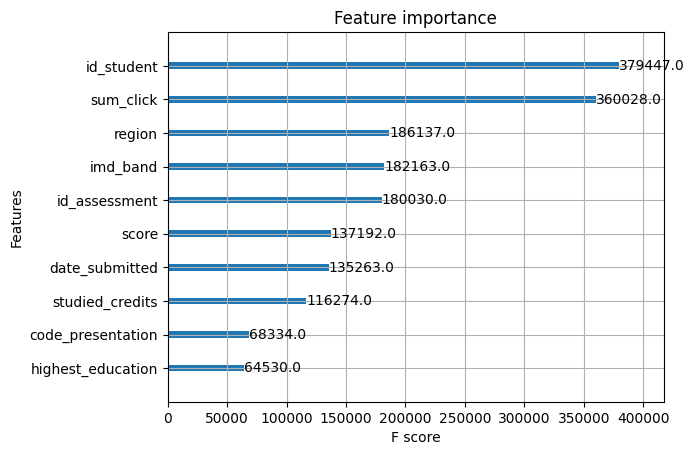

In [32]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_model, max_num_features=10)  # Show top 10 features
plt.show()

Try SHAP for Explainability (Optional but Useful)

SHAP (SHapley Additive exPlanations) gives a more detailed analysis of feature importance:


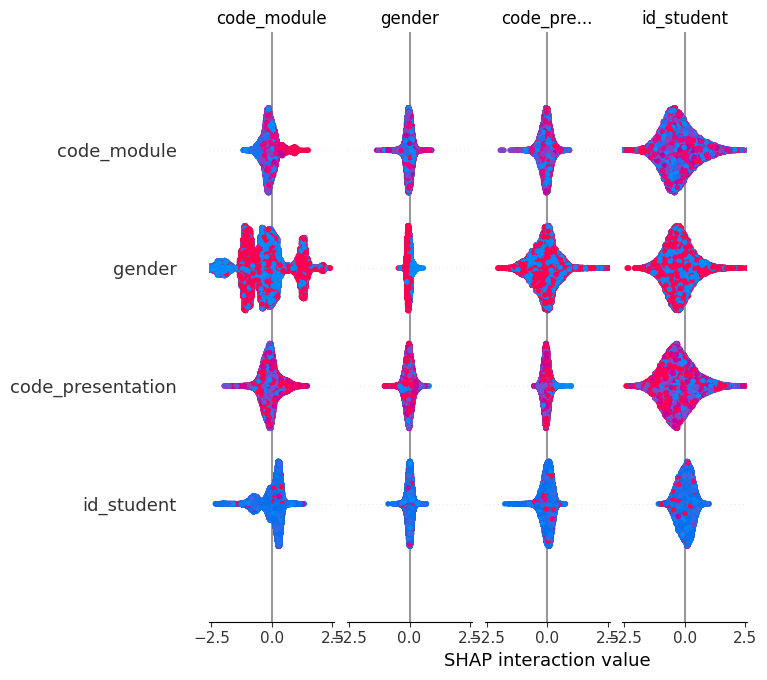

In [33]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test, approximate=True)  # Faster computation
shap.summary_plot(shap_values, X_test)



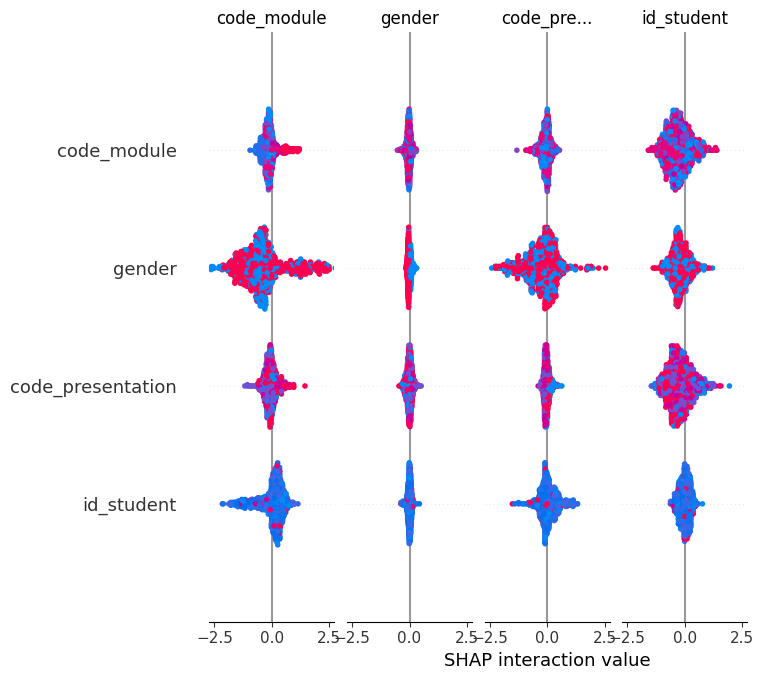

In [34]:
sample_size = 1000  # Reduce to a smaller number
X_test_sample = X_test.sample(sample_size, random_state=42)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

shap.summary_plot(shap_values, X_test_sample)


In [35]:
import joblib

joblib.dump(xgb_model, "optimized_xgboost_model.pkl")


['optimized_xgboost_model.pkl']

# **Convert Data for Deep Learning Models**